<a href="https://colab.research.google.com/github/dung18520632/NhanDien_CS338.L21/blob/main/Bird-eye-view_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install opencv-python==4.4.0.46 -i https://pypi.douban.com/simple

Looking in indexes: https://pypi.douban.com/simple
     |████████████████████████████████| 49.5MB 61kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [1]:
%cd /content/drive/MyDrive/Calibration

/content/drive/MyDrive/Calibration


In [2]:
%cd Social-Distance-Surveillance

/content/drive/MyDrive/Calibration/Social-Distance-Surveillance


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sqrt
from helper_functions import *
import sys

In [4]:
original_image_BGR = cv2.imread('data/MOT20_02_raw_frame_100.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
main_header = cv2.imread('templates/main_header.jpg')

image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)

image Shape (540, 960, 3)


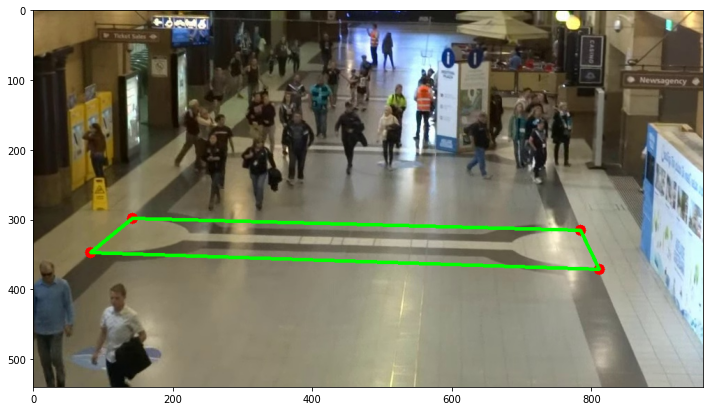

In [5]:
source_points = np.float32([[142., 298.],
                           [784., 315.],
                           [811., 371.],
                           [ 82., 347.]])
for point in source_points:
    cv2.circle(original_image_RGB_copy, tuple(point), 8, (255, 0, 0), -1)

points = source_points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()

In [6]:
src=source_points
dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])

dst_size=(800,1080)
dst = dst * np.float32(dst_size)

H_matrix = cv2.getPerspectiveTransform(src, dst)
print("The perspective transform matrix:")
print(H_matrix)


The perspective transform matrix:
[[ 4.64100594e+00  8.20914118e+00 -2.16714663e+03]
 [ 8.94136789e-02  2.14071423e+01 -1.19908691e+03]
 [ 3.12807115e-04  1.61722589e-02  1.00000000e+00]]


In [7]:
pts= np.float32([[[252., 314.],
                 [323., 316.],
                 [238., 347.]]])
# dst = np.array([[252,314],[323,316],[238,347]],np.float32)
warped_pt=cv2.perspectiveTransform(pts,H_matrix)[0]

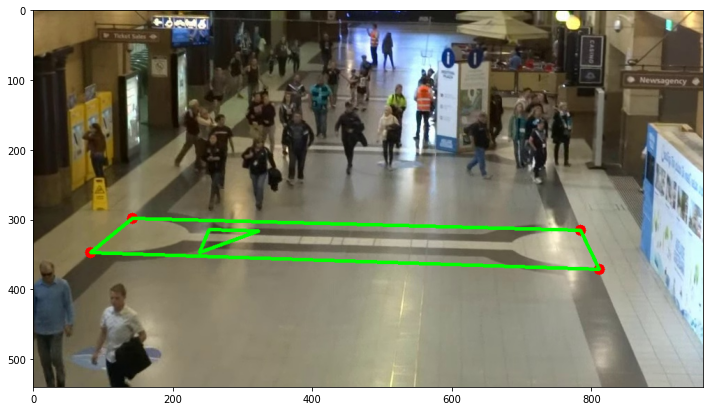

In [8]:
points = pts.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()

In [9]:
print(warped_pt)

[[256.63126 900.6599 ]
 [310.0694  900.6644 ]
 [267.1142  934.8287 ]]


In [10]:
warped_pt[1][0]


310.0694

In [11]:
distance_w = np.sqrt((warped_pt[0][0] - warped_pt[1][0]) ** 2 + (warped_pt[0][1] - warped_pt[1][1]) ** 2)
distance_h = np.sqrt((warped_pt[0][0] - warped_pt[2][0]) ** 2 + (warped_pt[0][1] - warped_pt[2][1]) ** 2)

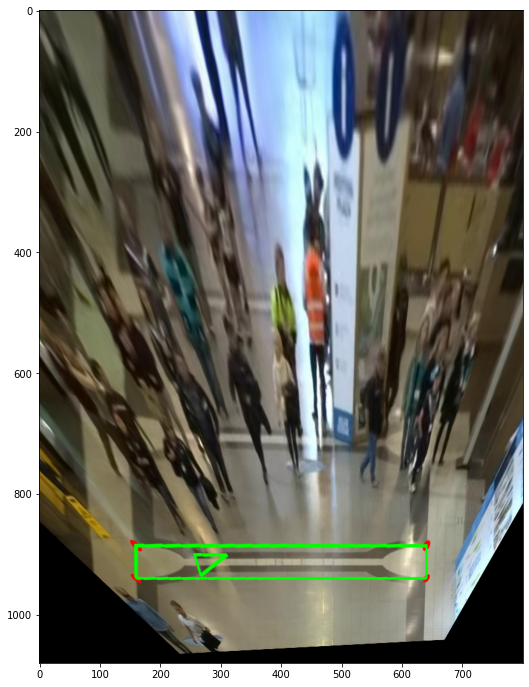

In [12]:
warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, dst_size)

plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

In [13]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [14]:
from darknet import *
confidence_threshold = 0.5
nms_threshold = 0.4

width = 608
height = 608

config = '/content/drive/MyDrive/darknet/cfg/yolov4.cfg'
weights = '/content/drive/MyDrive/darknet/yolov4.weights'
classes = '/content/drive/MyDrive/darknet/cfg/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

In [15]:
%cd /content/drive/MyDrive/Calibration/Social-Distance-Surveillance

/content/drive/MyDrive/Calibration/Social-Distance-Surveillance


In [16]:
model = create_model(config, weights)
output_layers = get_output_layers(model)

In [17]:
blob = blob_from_image(original_image_RGB, (width, height))
model.setInput(blob)
#Trả về vị trí box (x,y,w_h,w_w,confidence)
outputs = model.forward(output_layers)

In [18]:
def get_image_boxes_1(outputs, image_width, image_height, classes, confidence_threshold=0.5, nms_threshold=0.4):
    class_ids = []
    confidences = []
    boxes = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            class_name = classes[class_id]
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_name== 'person':
                cx, cy, width, height = (detection[0:4] * np.array([image_width, image_height, image_width, image_height])).astype("int")
                x = int(cx - width / 2)
                y = int(cy - height / 2)
                boxes.append([x, y, int(width), int(height),cx,cy])
                confidences.append(float(confidence))
    nms_indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)
    return [boxes[ind] for ind in nms_indices.flatten()]

In [21]:
boxes = get_image_boxes_1(outputs, image_width, image_height, coco_classes)
print(boxes)

[[-2, 360, 62, 179, 29, 450], [78, 393, 91, 146, 124, 466], [619, 146, 36, 94, 637, 193], [491, 136, 35, 90, 509, 181], [301, 181, 41, 104, 322, 233], [430, 131, 49, 103, 455, 183], [706, 151, 27, 87, 720, 195], [546, 91, 28, 108, 560, 145], [741, 145, 24, 74, 753, 182], [203, 131, 38, 96, 222, 179], [359, 146, 41, 101, 380, 197]]


In [24]:
def compute_point_perspective_transformation(matrix,boxes):
    list_downoids = [[box[4], box[5]+box[3]//2] for box in boxes]
    list_points_to_detect = np.float32(list_downoids).reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(list_points_to_detect, matrix)
    transformed_points_list = list()
    for i in range(0,transformed_points.shape[0]):
        transformed_points_list.append([transformed_points[i][0][0],transformed_points[i][0][1]])
    return np.array(transformed_points_list).astype('int')

In [25]:
birds_eye_points = compute_point_perspective_transformation(H_matrix, boxes)
print(birds_eye_points)


[[ 245 1063]
 [ 290 1060]
 [ 543  786]
 [ 425  765]
 [ 291  863]
 [ 378  781]
 [ 616  780]
 [ 470  708]
 [ 654  744]
 [ 153  776]
 [ 317  806]]


In [26]:
def eucledian_distance_1(point1, point2,distance_w, distance_h):
    x1,y1 = point1
    x2,y2 = point2
    h=abs(y2-y1)
    w=abs(x2-x1)
    dis_w = float((w/distance_w)*180)
    dis_h = float((h/distance_h)*180)
    
    return int(np.sqrt(((dis_h)**2) + ((dis_w)**2)))

In [29]:
def get_red_green_boxes_1(distance_allowed,birds_eye_points,boxes):
    red_boxes = []
    green_boxes = []

    new_boxes = [tuple(box) + tuple(result) for box, result in zip(boxes, birds_eye_points)]
    for i in range(0, len(new_boxes)-1):
            for j in range(i+1, len(new_boxes)):
                cxi,cyi = new_boxes[i][6:]
                cxj,cyj = new_boxes[j][6:]
                distance = eucledian_distance_1([cxi,cyi], [cxj,cyj],distance_w, distance_h)
                
                if distance < distance_allowed:
                    red_boxes.append(new_boxes[i])
                    red_boxes.append(new_boxes[j])

    green_boxes = list(set(new_boxes) - set(red_boxes))
    red_boxes = list(set(red_boxes))

    return (green_boxes, red_boxes)

In [30]:
min_distance = 60
green_boxes,red_boxes=get_red_green_boxes_1(min_distance, birds_eye_points, boxes)

245 1063
245 1063
245 1063
245 1063
245 1063
245 1063
245 1063
245 1063
245 1063
245 1063
290 1060
290 1060
290 1060
290 1060
290 1060
290 1060
290 1060
290 1060
290 1060
543 786
543 786
543 786
543 786
543 786
543 786
543 786
543 786
425 765
425 765
425 765
425 765
425 765
425 765
425 765
291 863
291 863
291 863
291 863
291 863
291 863
378 781
378 781
378 781
378 781
378 781
616 780
616 780
616 780
616 780
470 708
470 708
470 708
654 744
654 744
153 776


In [ ]:
[(-2, 360, 62, 179, 29, 450, 245, 1063), (78, 393, 91, 146, 124, 466, 290, 1060), (619, 146, 36, 94, 637, 193, 543, 786), (491, 136, 35, 90, 509, 181, 425, 765), (301, 1

In [ ]:
birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)
# plt.figure(figsize=(8, 8))
# plt.imshow(cv2.cvtColor(birds_eye_view_image, cv2.COLOR_RGB2BGR))
# plt.show()

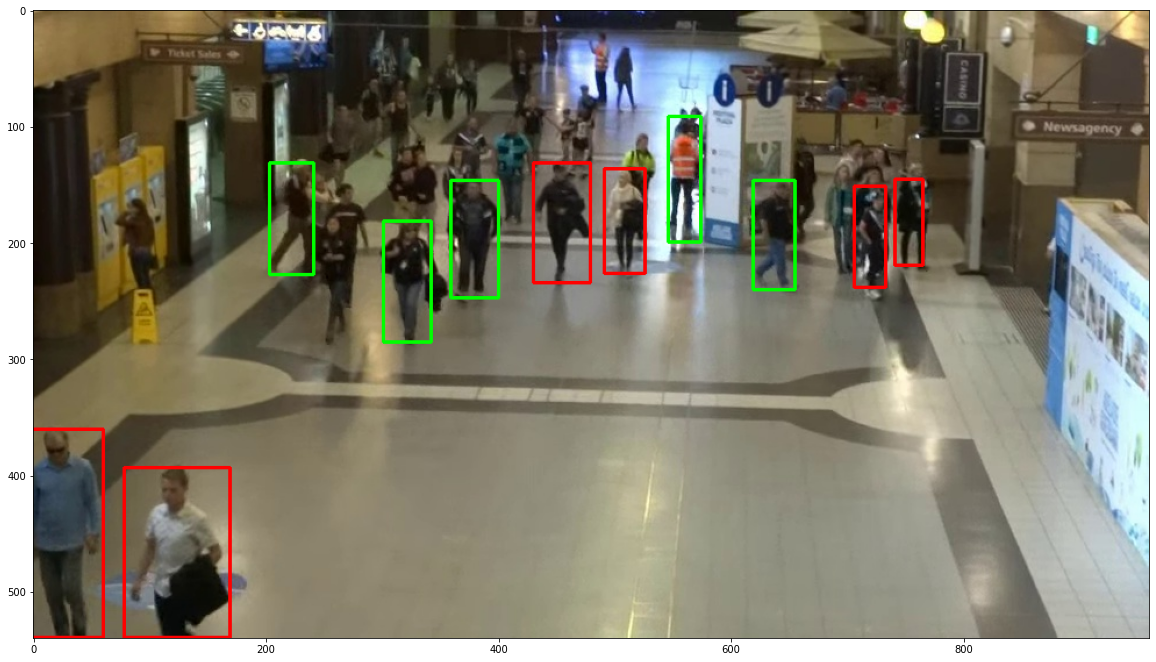

In [ ]:
box_red_green_image = get_red_green_box_image(original_image_BGR.copy(),green_box,red_box)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(box_red_green_image, cv2.COLOR_RGB2BGR))
plt.show()

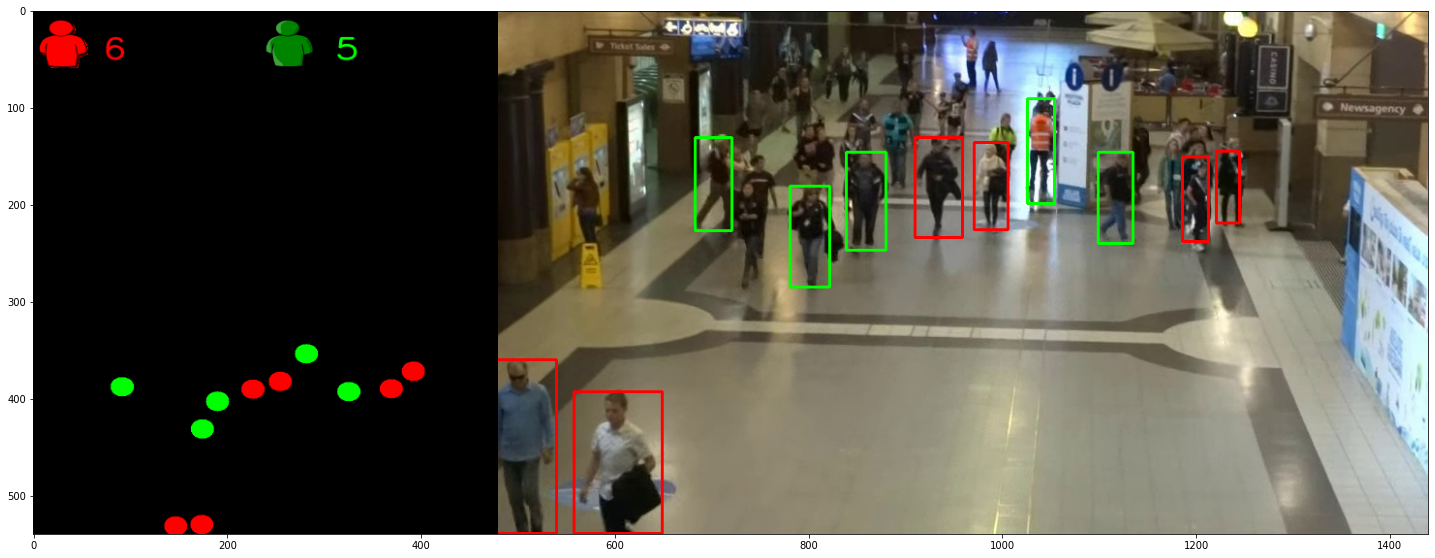

In [ ]:
combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
plt.figure(figsize=(25, 20))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
plt.show()

In [ ]:
video = cv2.VideoCapture('/content/People2_10s.mp4')
writer = None
frame_number = 0
print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
while True:
  
  ret,frame = video.read()

  if not ret:
    break

  image_height, image_width = frame.shape[:2]

  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  blob = blob_from_image(image, (width, height))
  model.setInput(blob)
  outputs = model.forward(output_layers)

  boxes = get_image_boxes(outputs, image_width, image_height, coco_classes)
  birds_eye_points = compute_point_perspective_transformation(H_matrix, boxes)
  green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes)
  birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height,eye_view_width=image_width//2)
  box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box)

  combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)

  frame_number += 1
  sys.stdout.write('%-20i|%-25i|%-25i|%-25i\n' % (frame_number,len(boxes),len(red_box),len(green_box)))

  # if frame_number >=20:
  #   break

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    writer = cv2.VideoWriter('/content/test.avi', fourcc, 15, (combined_image.shape[1], combined_image.shape[0]), True)

  writer.write(combined_image)

  del image,outputs,combined_image,birds_eye_view_image

print(' ')
writer.release()
video.release()

Processing Frame    |Total Detected Person    |Red Markerd Person       |Green Marked Person      
1                   |15                       |10                       |5                        
2                   |16                       |10                       |6                        
3                   |15                       |10                       |5                        
4                   |15                       |10                       |5                        
5                   |17                       |10                       |7                        
6                   |17                       |10                       |7                        
7                   |16                       |10                       |6                        
8                   |17                       |10                       |7                        
9                   |16                       |12                       |4                        
10        